# Set up simple CNN with radar data

In [1]:
import iris
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

## Work with data from S3 bucket:

In [3]:
files = [f'/s3/mo-uki-radar-comp/20180915{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,8)]

## Read data and reshape into groups of 3 timesteps on a 100x100 grid:

In [4]:
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


In [5]:
print(np.shape(cube_data))

(20, 2000, 1000)


In [6]:
split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/4))
print(np.shape(split_data_1))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
print(np.shape(split_data_1))
dataset = split_data_1.reshape(-1,4,100,100)
print(np.shape(dataset))

(5, 4, 2000, 1000)
(10, 20, 5, 4, 100, 100)
(1000, 4, 100, 100)


## Convert to torch tensors and load as training dataset

In [7]:
tensor = torch.stack([torch.Tensor(i) for i in dataset])

In [8]:
train_loader = utils.DataLoader(tensor, batch_size=1)

## Create validation dataset

In [9]:
files = [f'/s3/mo-uki-radar-comp/20180925{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,8)]

In [10]:
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data
split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/4))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
dataset = split_data_1.reshape(-1,4,100,100)
print(np.shape(dataset))

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


(1000, 4, 100, 100)


Convert to torch tensor:

In [11]:
tensor = torch.stack([torch.Tensor(i) for i in dataset])

val_loader = utils.DataLoader(tensor, batch_size=1)

## Set up CNN architecture

In [12]:
from torch.autograd import Variable
import torch.nn.functional as F

class CNN(torch.nn.Module):
    
    def __init__(self):
        self.as_super = super(CNN, self)
        self.as_super.__init__()

        self.conv1 = torch.nn.Conv2d(3, 5, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.deconv1 = torch.nn.ConvTranspose2d(5, 5, kernel_size=5, stride=1, padding=2)
        self.unpool1 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv_1 = torch.nn.Conv2d(5, 1, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        orig = x
        
        x = torch.relu(self.conv1(x))
        size1 = x.size()
        #print(x.size())
        x, inds1 = self.pool1(x)
        #print(x.size())
        x = torch.relu(self.deconv1(x))
        #print(x.size())
        x = self.unpool1(x, inds1, size1)
        #print(x.size())
        x = self.conv_1(x)
        #print(x.size())
        
        return(x)


## Create loss function

In [13]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    
    #Loss function
    loss = torch.nn.MSELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

## Train the model

In [14]:
def train_net(net, batch_size, n_epochs, learning_rate):
    
    #Print the hyperparameters of the training run:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    n_batches = len(train_loader)
    
    #Create the loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs from training data
            inputs, labels = data[:,:3], data[:,3]
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs[0], labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t training loss: {:.2f}".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss))
                
                #Reset running loss
                running_loss = 0.0
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for data in val_loader:

            inputs, labels = data[:,:3], data[:,3]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs[0], labels)
            total_val_loss += val_loss_size.data.item()
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader))) #check this is printing what we expect
        
    print("Training finished")

In [15]:
cnn = CNN()
train_net(cnn, batch_size=10, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 10
epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 training loss: 2.24
Epoch 1, 20% 	 training loss: 4.03
Epoch 1, 30% 	 training loss: 7.10
Epoch 1, 40% 	 training loss: 5.18
Epoch 1, 50% 	 training loss: 2.61
Epoch 1, 60% 	 training loss: 2.04
Epoch 1, 70% 	 training loss: 0.21
Epoch 1, 80% 	 training loss: 0.04
Epoch 1, 90% 	 training loss: 0.06
Validation loss = 0.00
Epoch 2, 10% 	 training loss: 1.70
Epoch 2, 20% 	 training loss: 2.94
Epoch 2, 30% 	 training loss: 6.06
Epoch 2, 40% 	 training loss: 6.37
Epoch 2, 50% 	 training loss: 2.40
Epoch 2, 60% 	 training loss: 2.02
Epoch 2, 70% 	 training loss: 0.23
Epoch 2, 80% 	 training loss: 0.04
Epoch 2, 90% 	 training loss: 0.06
Validation loss = 0.00
Epoch 3, 10% 	 training loss: 1.56
Epoch 3, 20% 	 training loss: 3.34
Epoch 3, 30% 	 training loss: 7.15
Epoch 3, 40% 	 training loss: 4.51
Epoch 3, 50% 	 training loss: 2.23
Epoch 3, 60% 	 training loss: 1.85
Epoch 3, 70% 	 training loss: 0.21
Epoc

## Plot outputs

In [48]:
def setup_plt(ax):
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_yticks(np.arange(0, 100, 10))
    plt.grid()
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    plt.setp(ax.yaxis.get_ticklabels(), visible=False)
    
def show_outputs(net, loader):
    for i, data in enumerate(loader):
        if ((i > 50) & (i < 100)):
            data = data.type('torch.FloatTensor')
            inputs, labels = data[:,:3], data[:,3]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
        
            fig = plt.figure(figsize=(16,8))
        
            ## change to just plot those with rain in the domain ##

            for i in range(3):
                ax = fig.add_subplot(2, 4, i+1)
                cf = plt.contourf(inputs[0,i], cmap=plt.cm.Greys)
                setup_plt(ax)
                if i == 0:
                    plt.title('inputs')
            
            ax = fig.add_subplot(2, 4, 4)
            cf = plt.contourf(labels[0], cmap=plt.cm.Greys)
            setup_plt(ax)
            plt.title('truth')
            ax = fig.add_subplot(2, 4, 8)
            cf = plt.contourf(val_outputs[0, 0].detach().numpy(), cmap=plt.cm.Greys)
            setup_plt(ax)
            plt.title('model')

            plt.tight_layout()

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


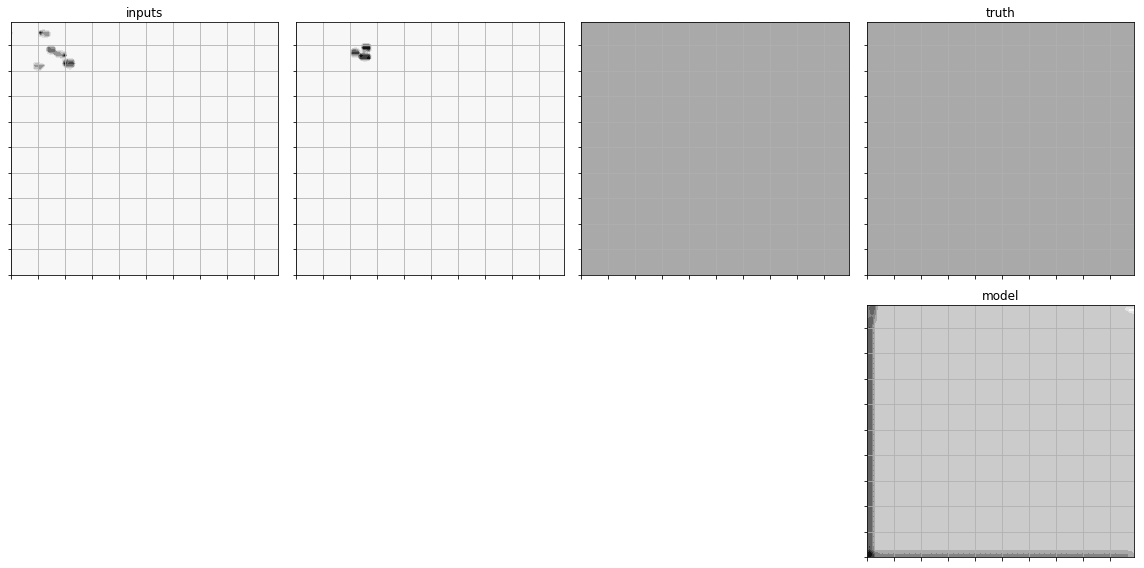

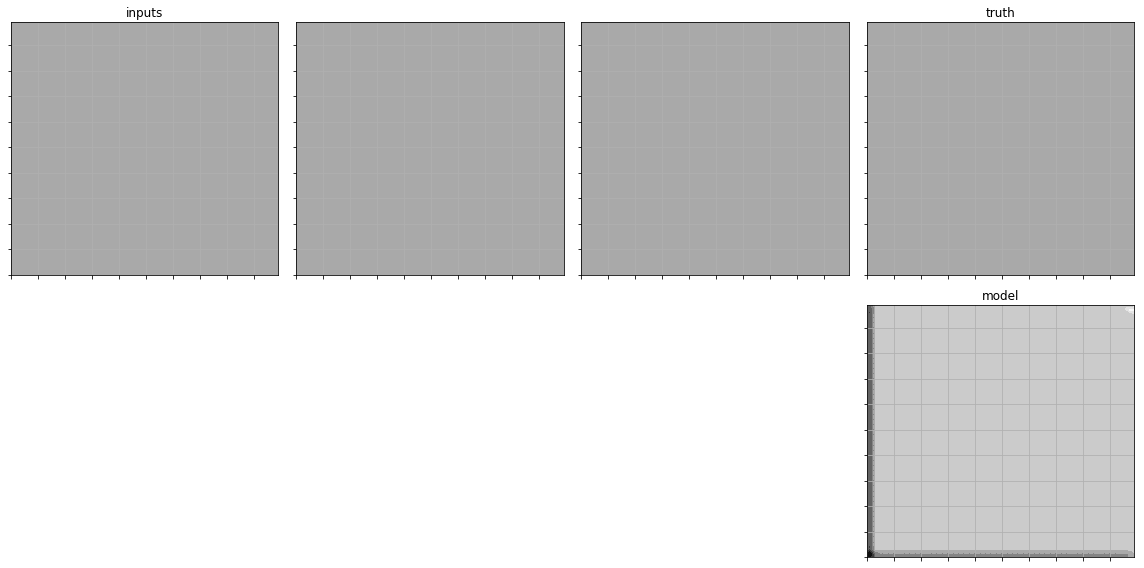

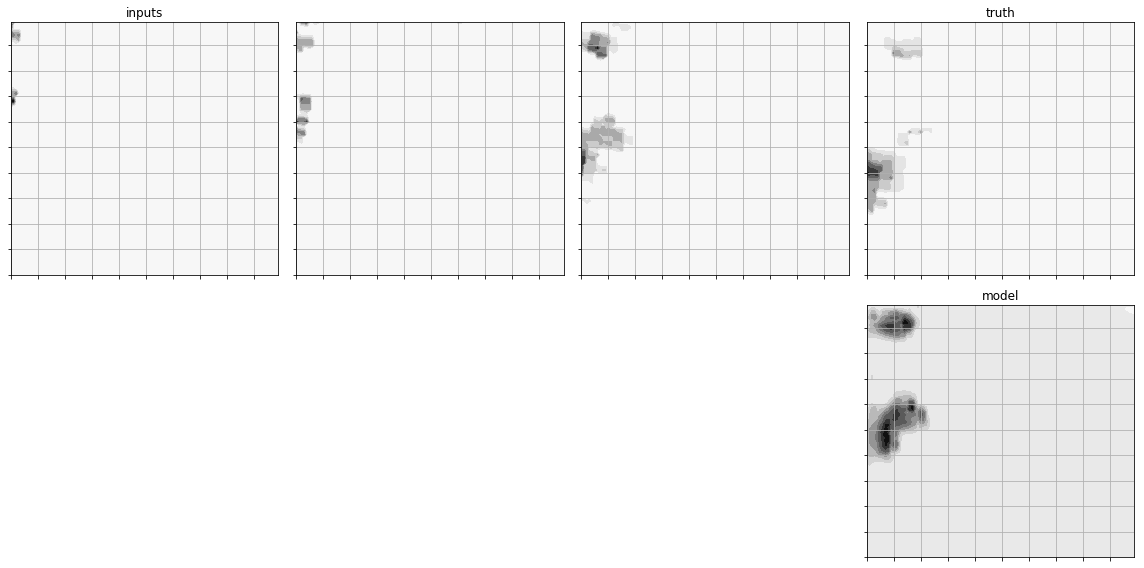

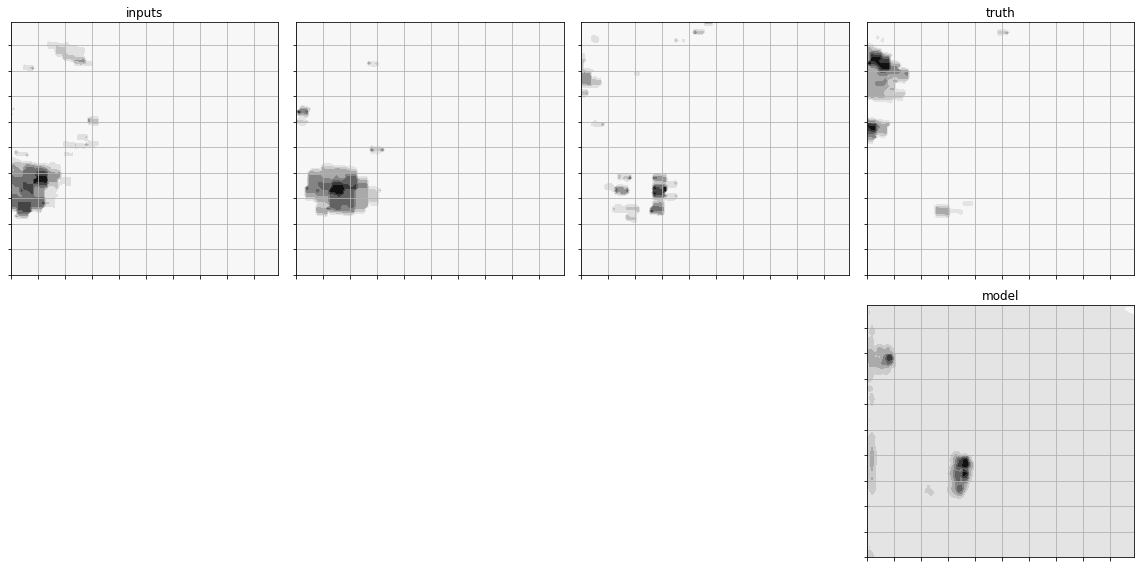

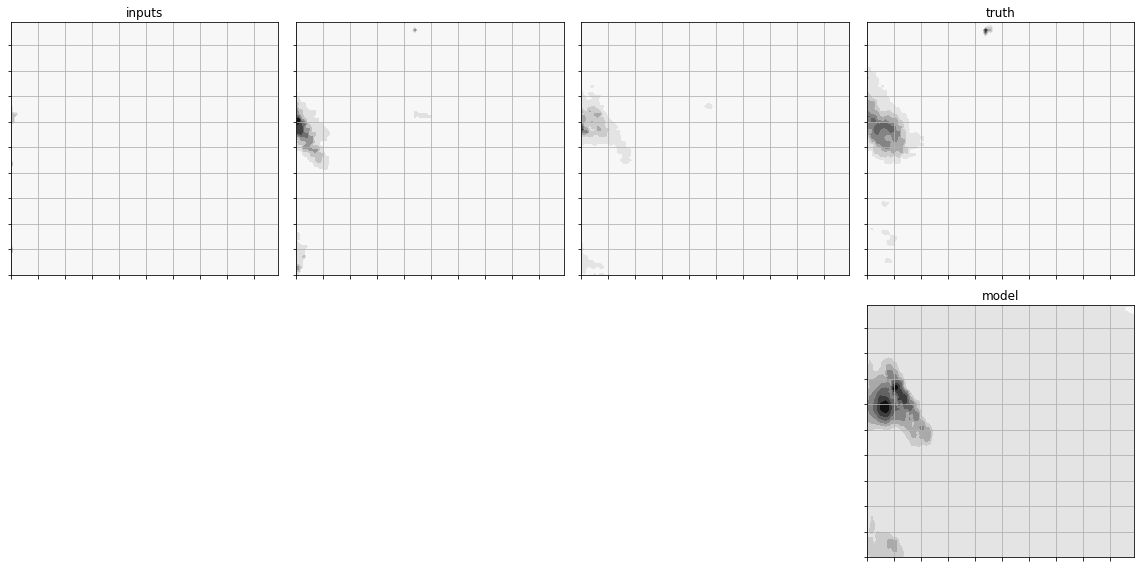

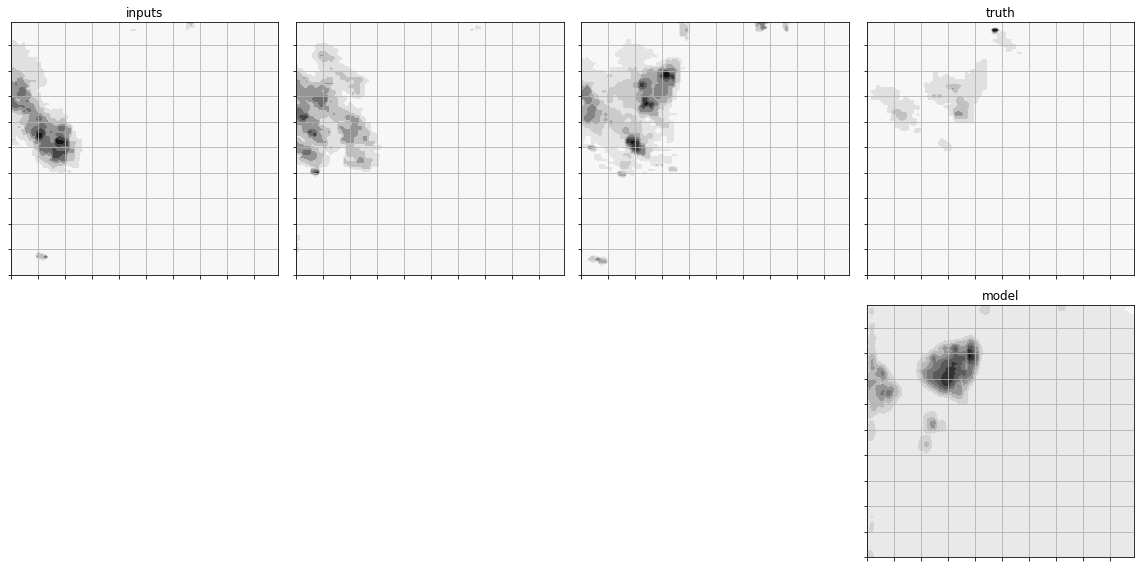

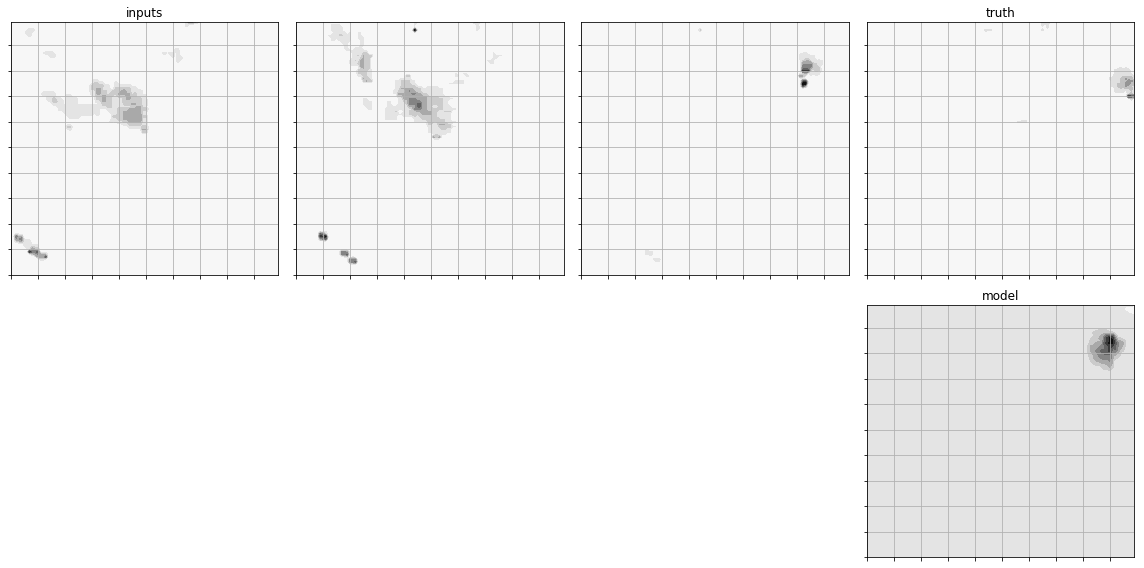

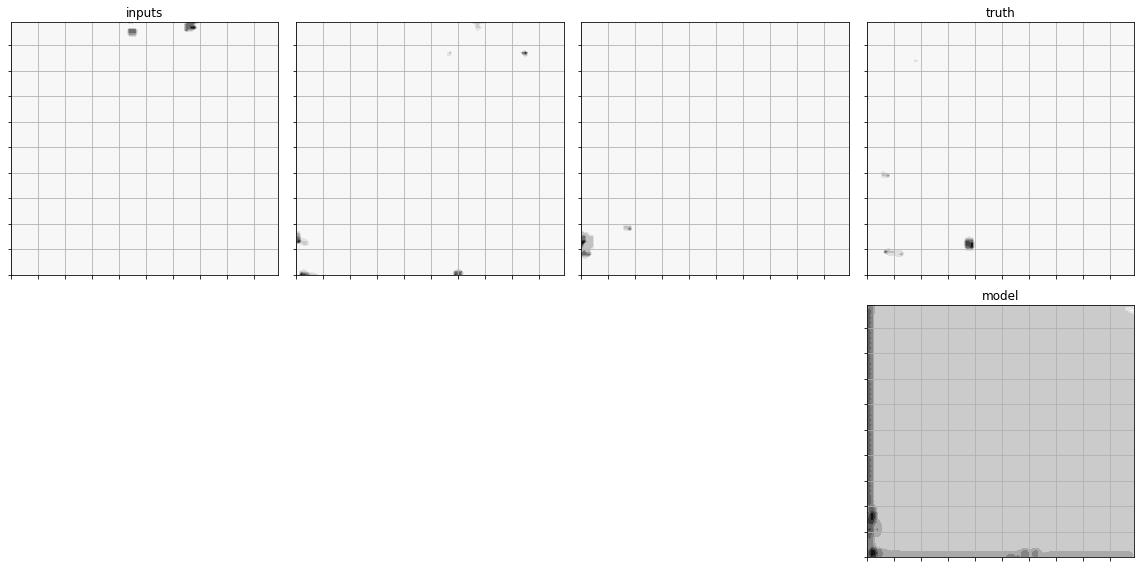

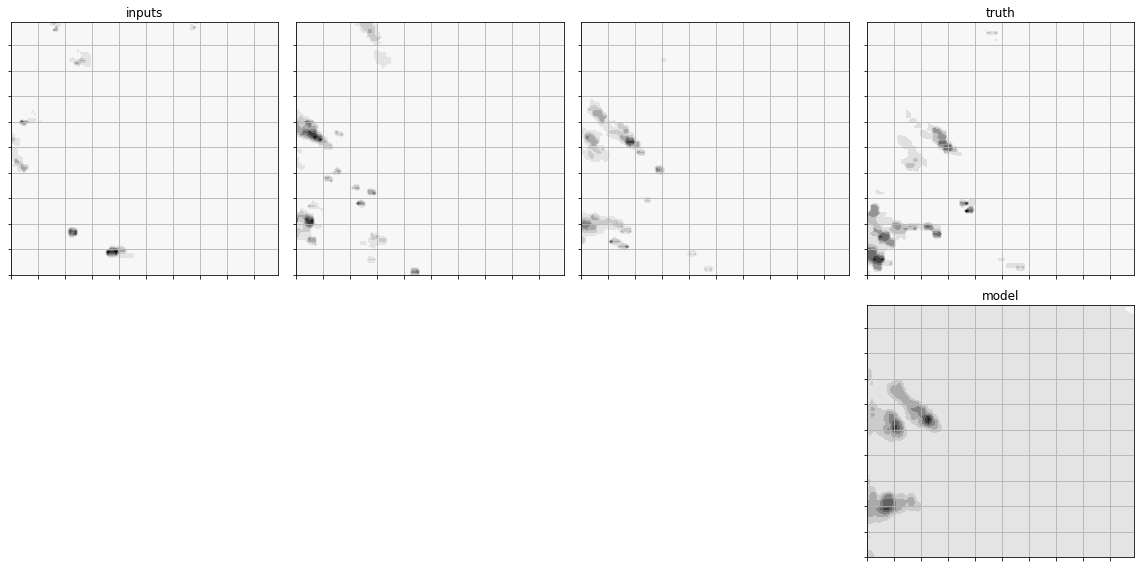

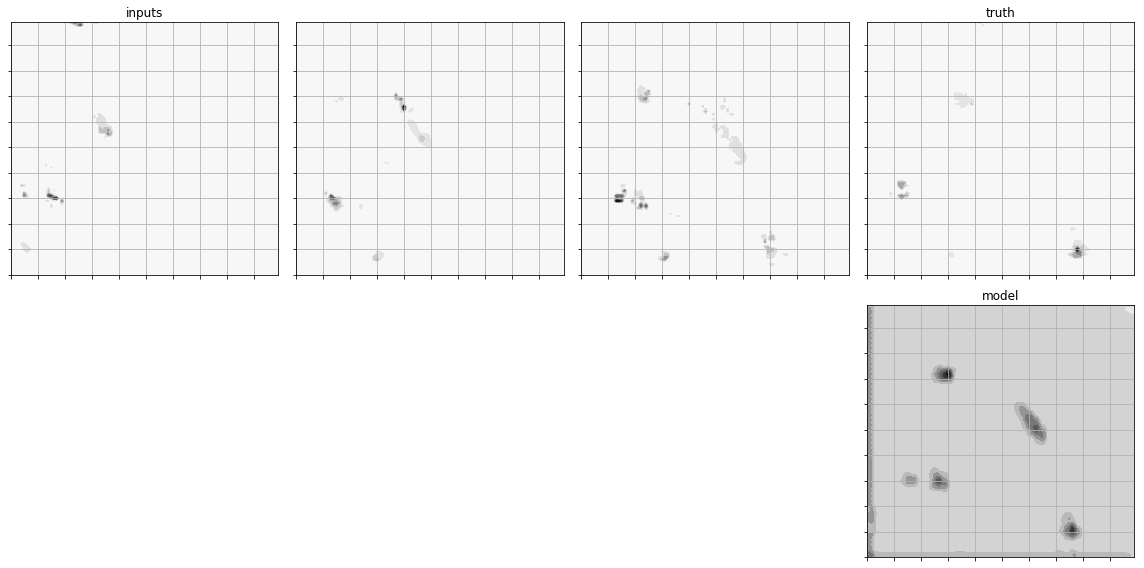

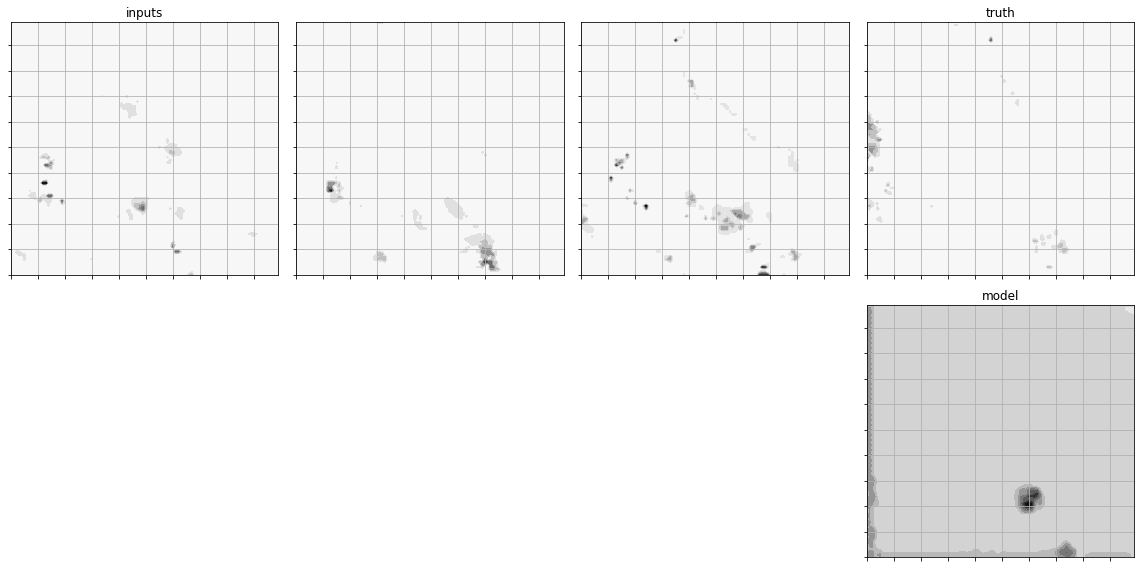

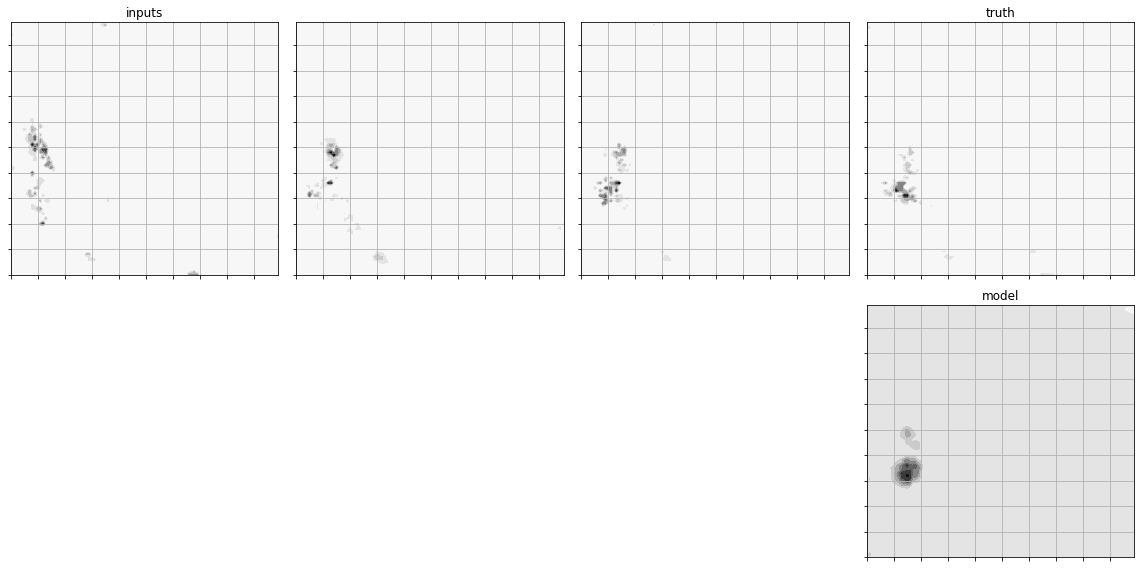

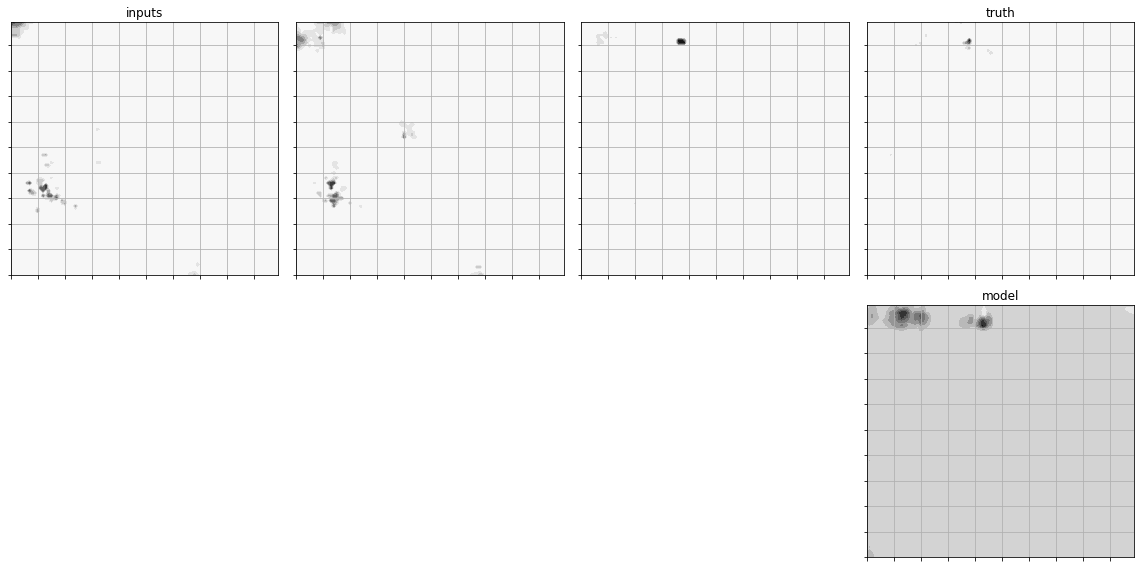

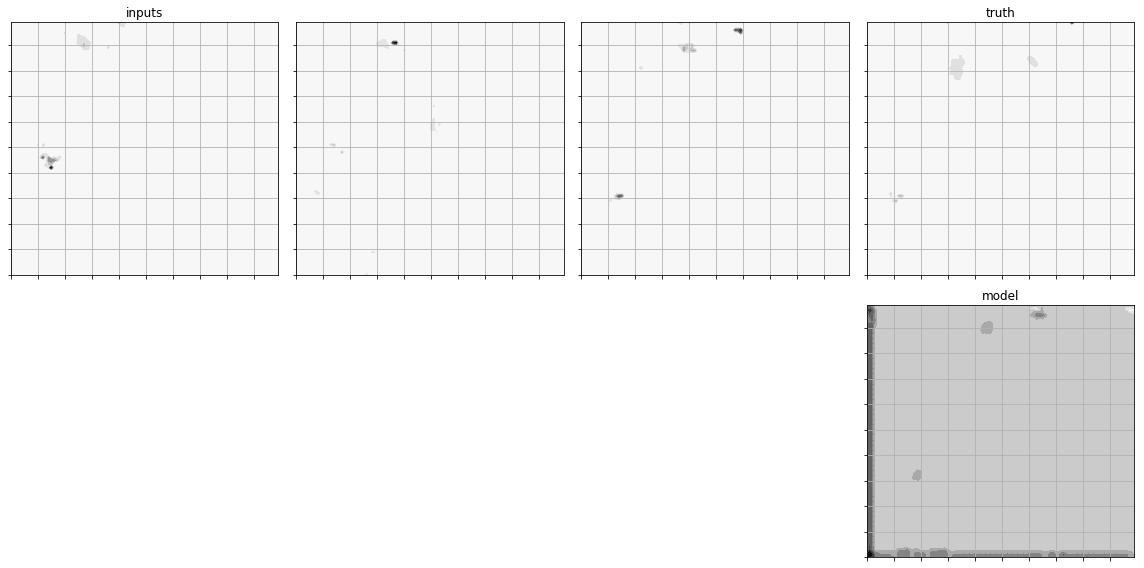

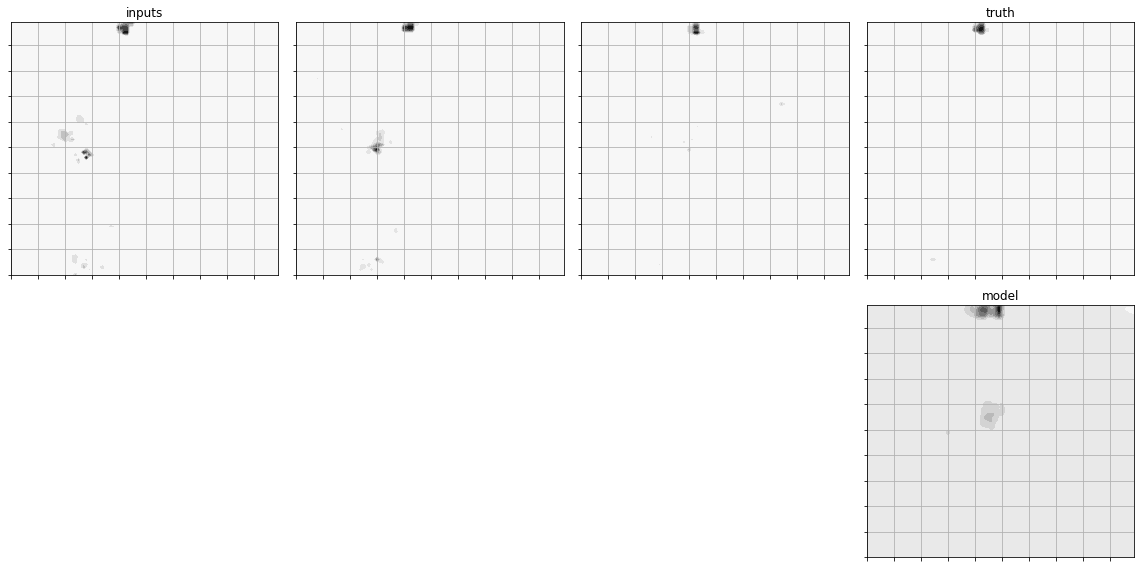

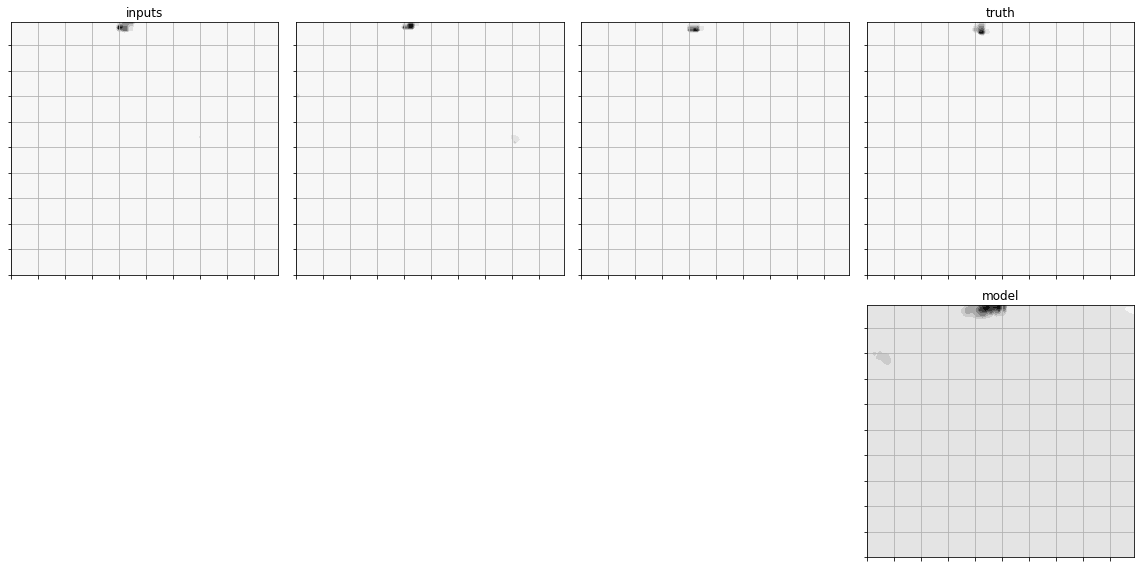

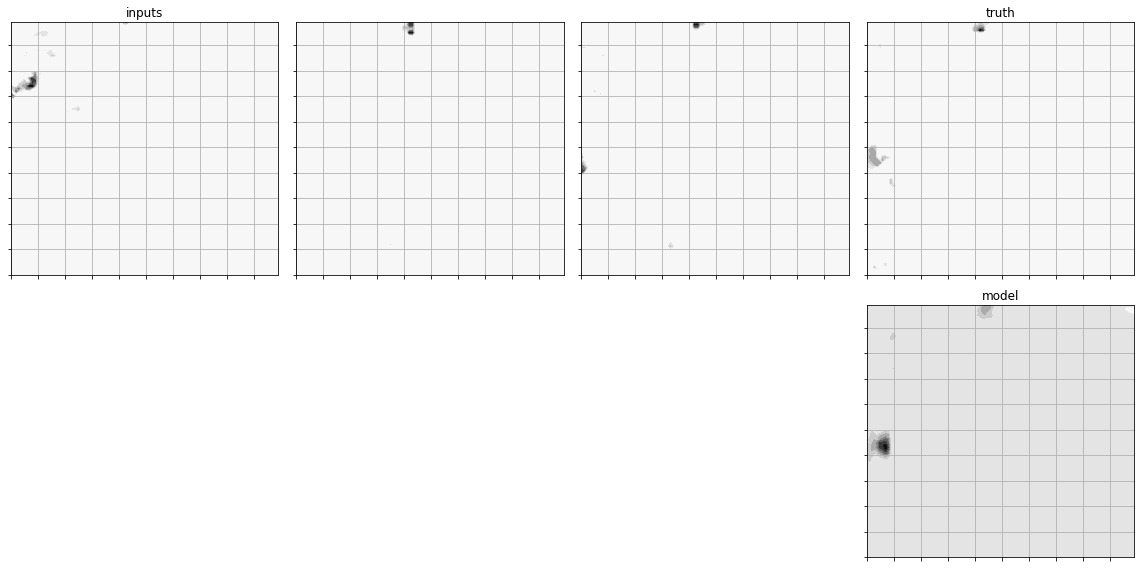

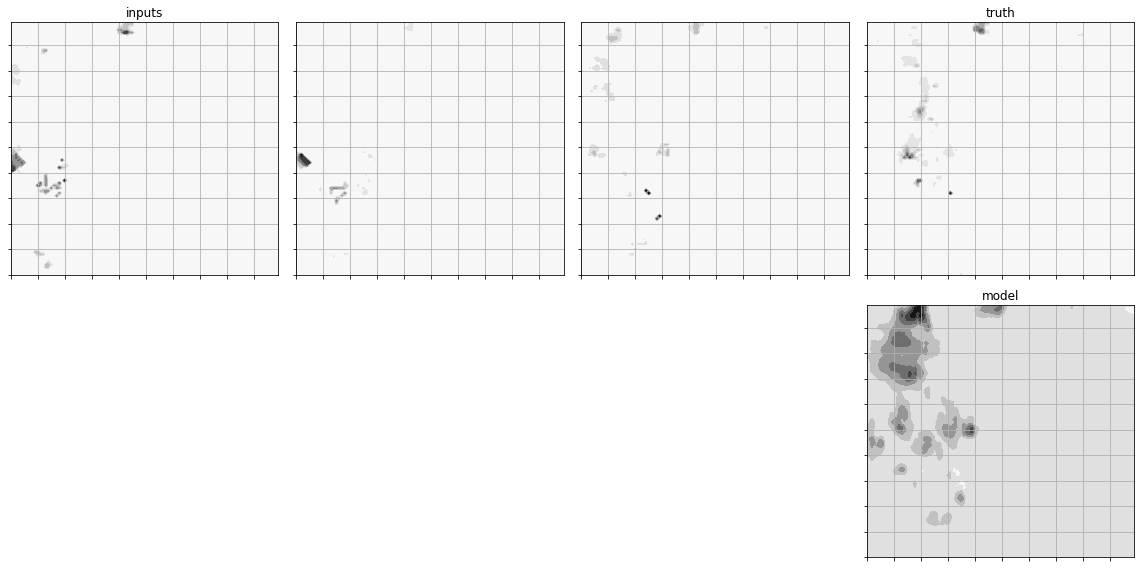

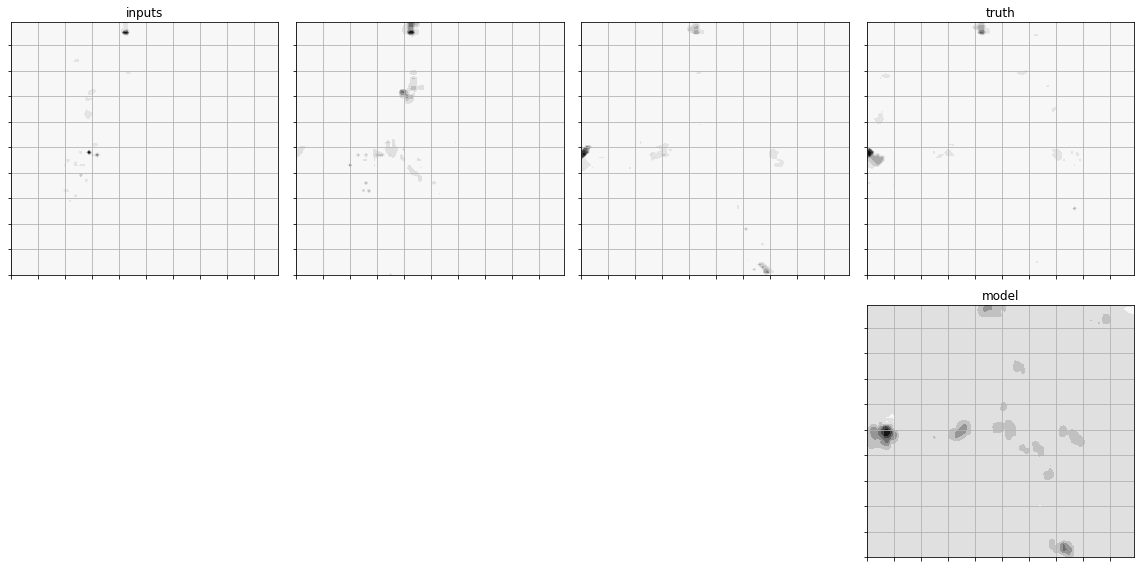

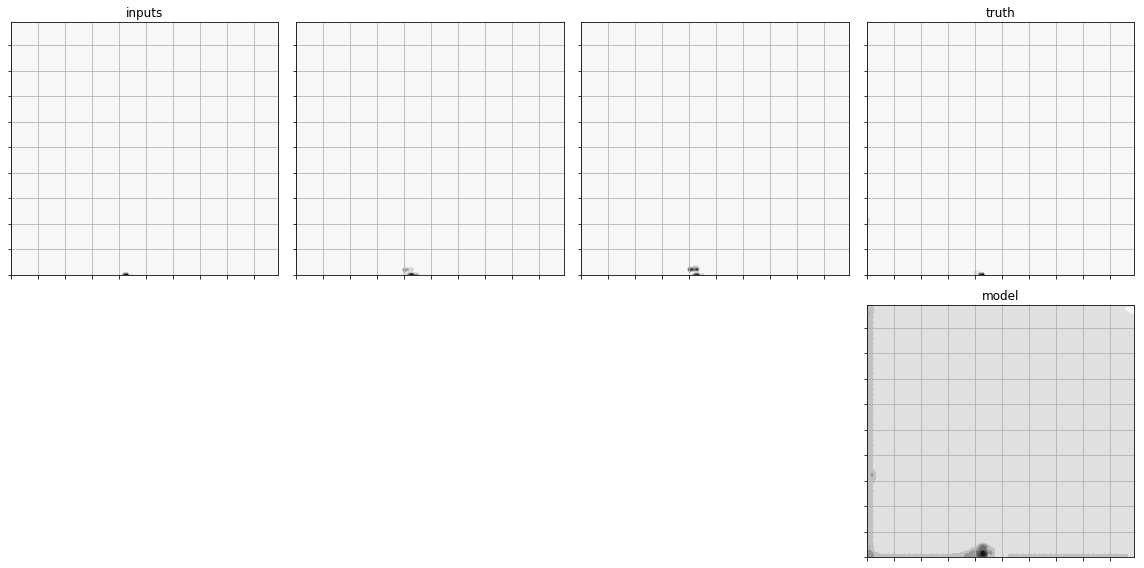

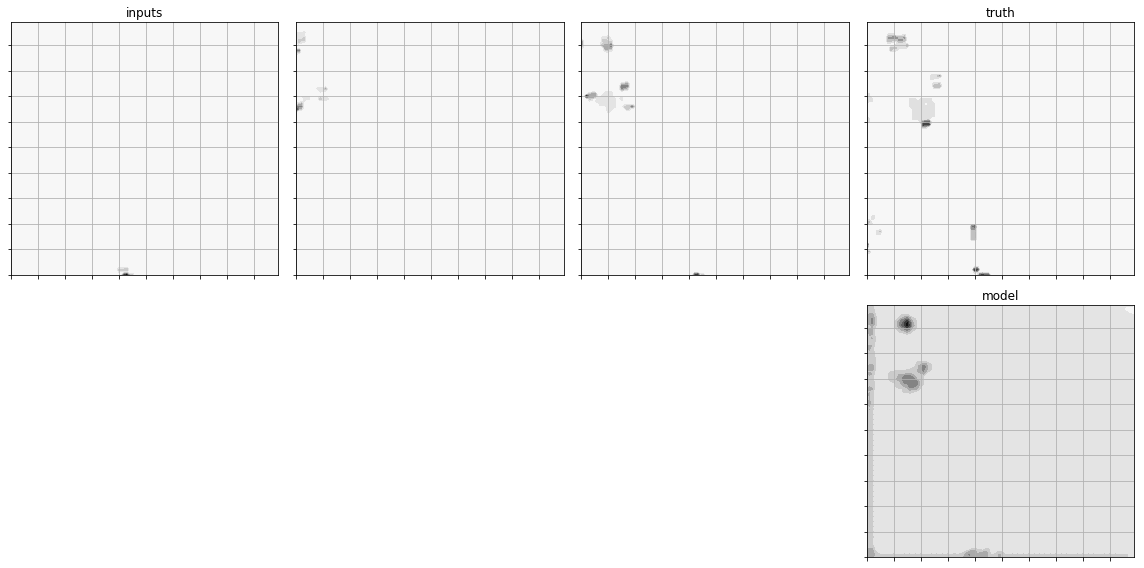

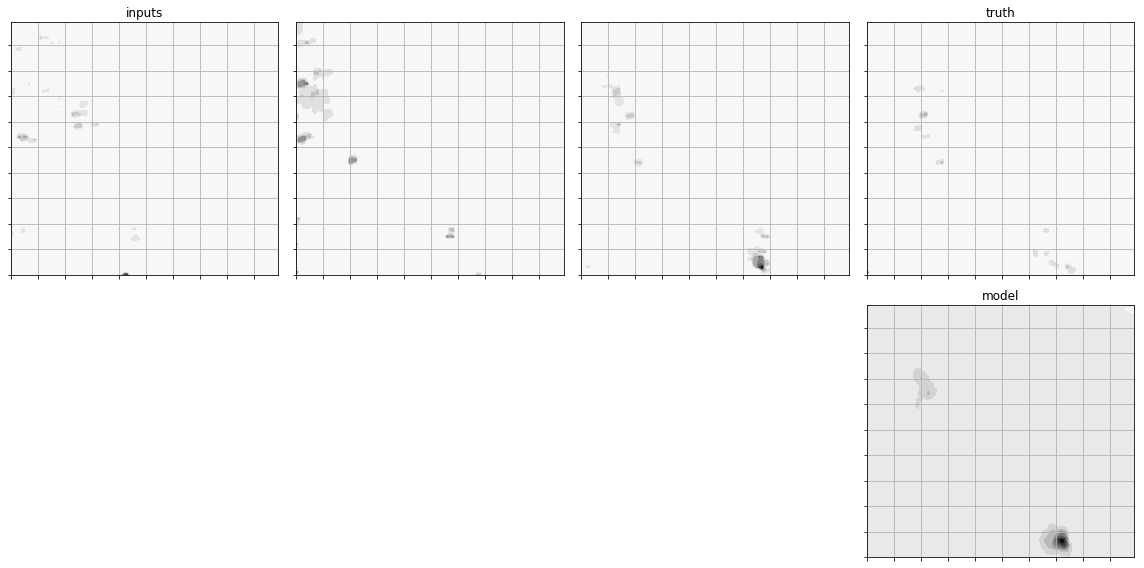

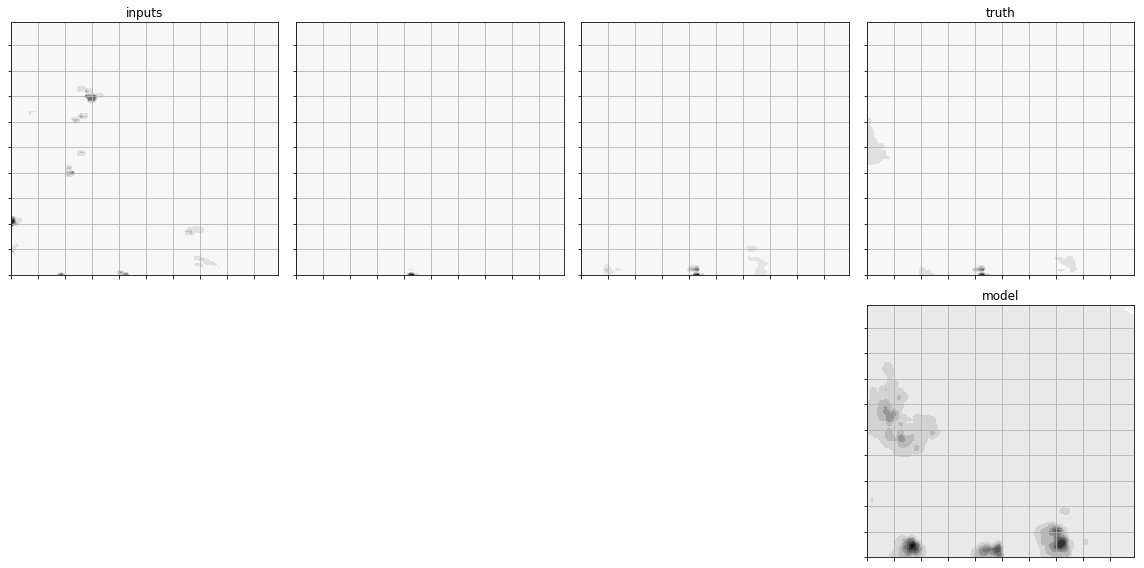

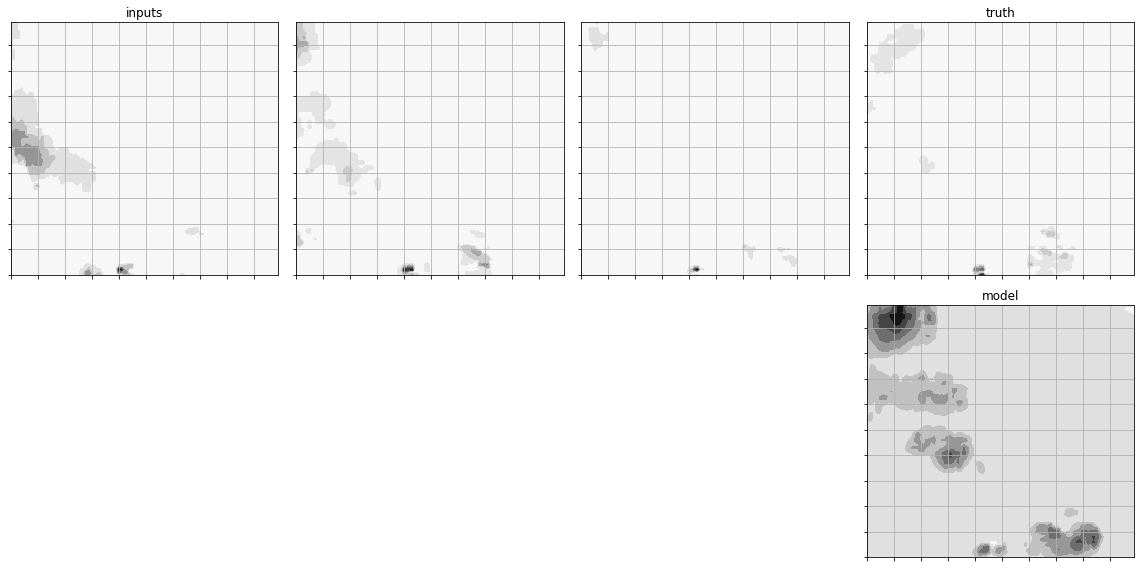

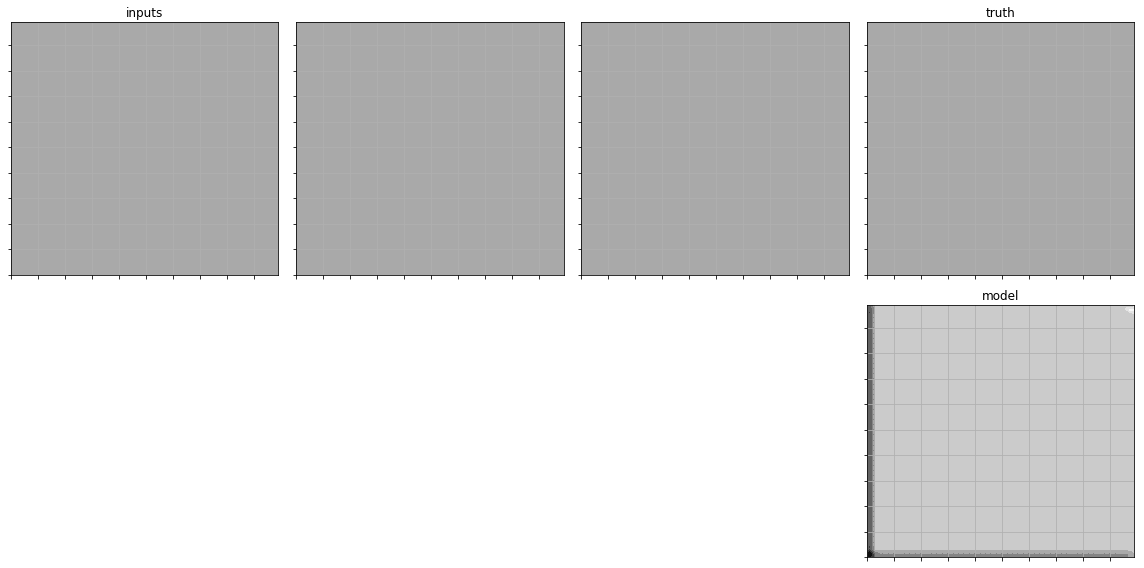

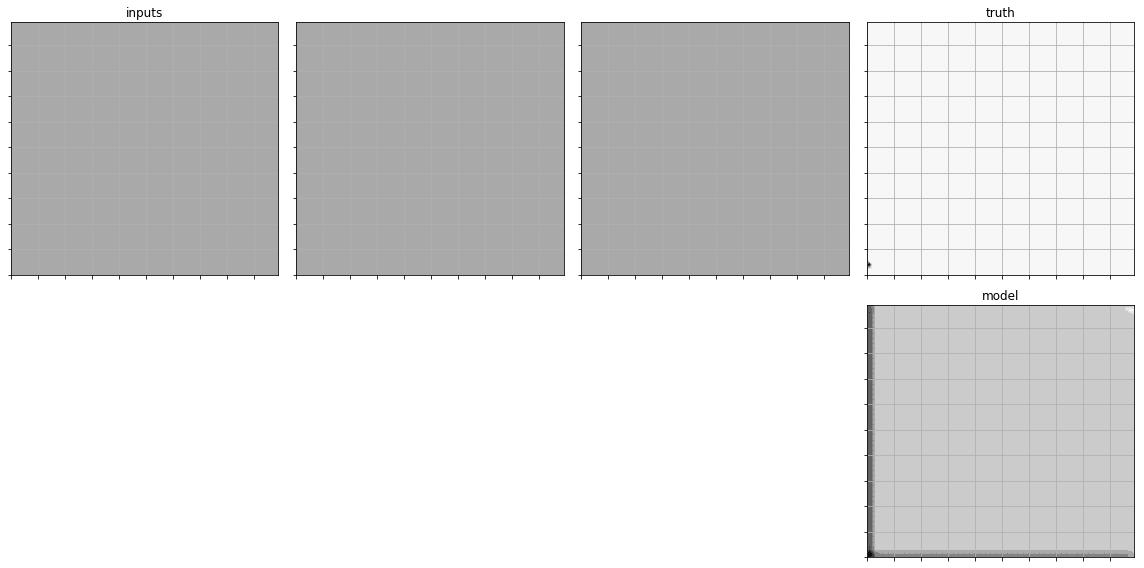

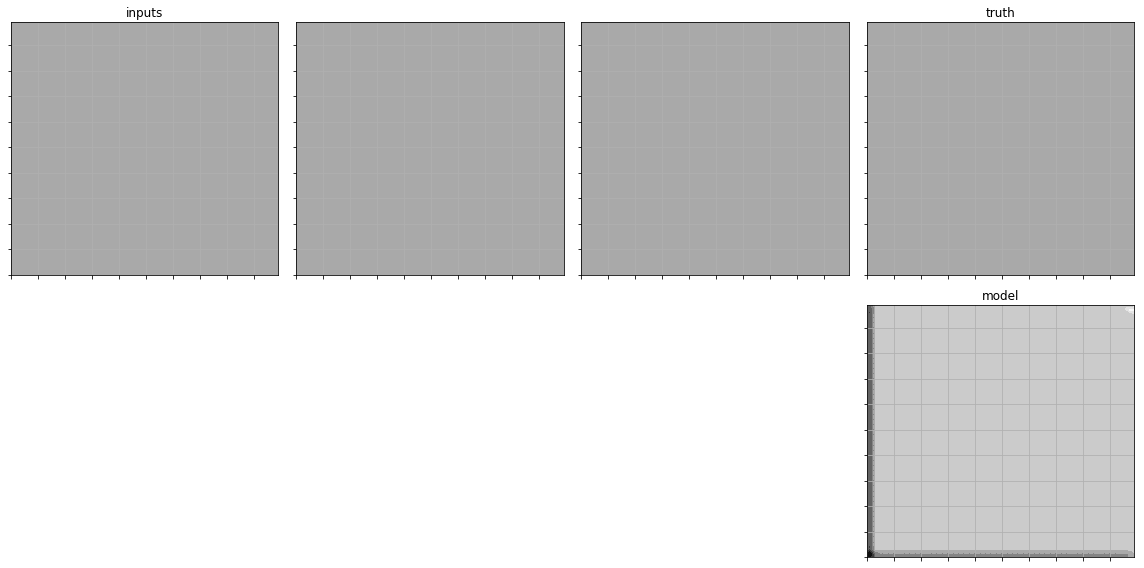

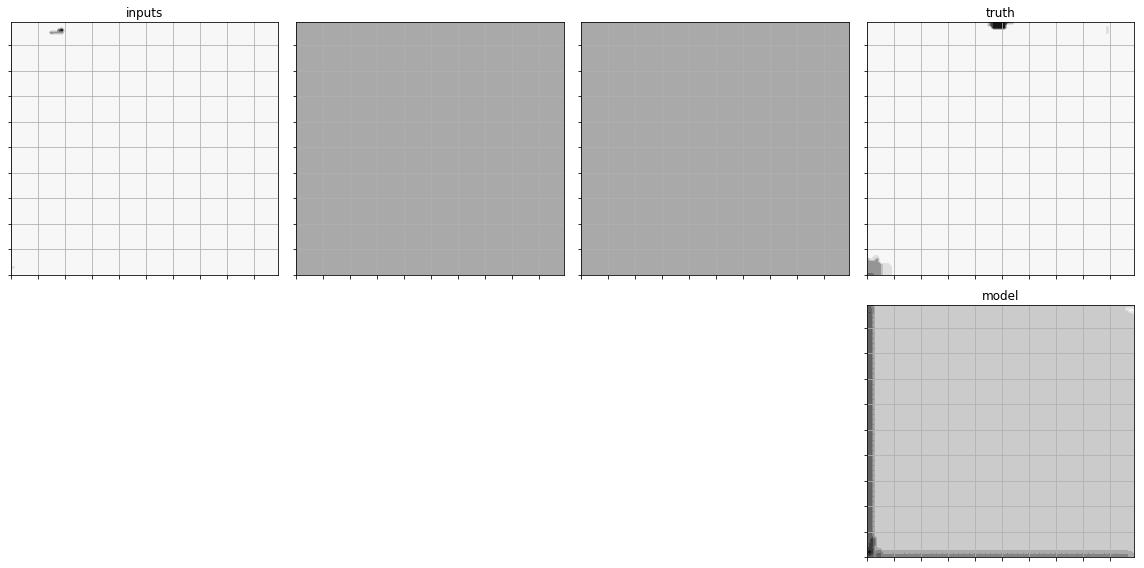

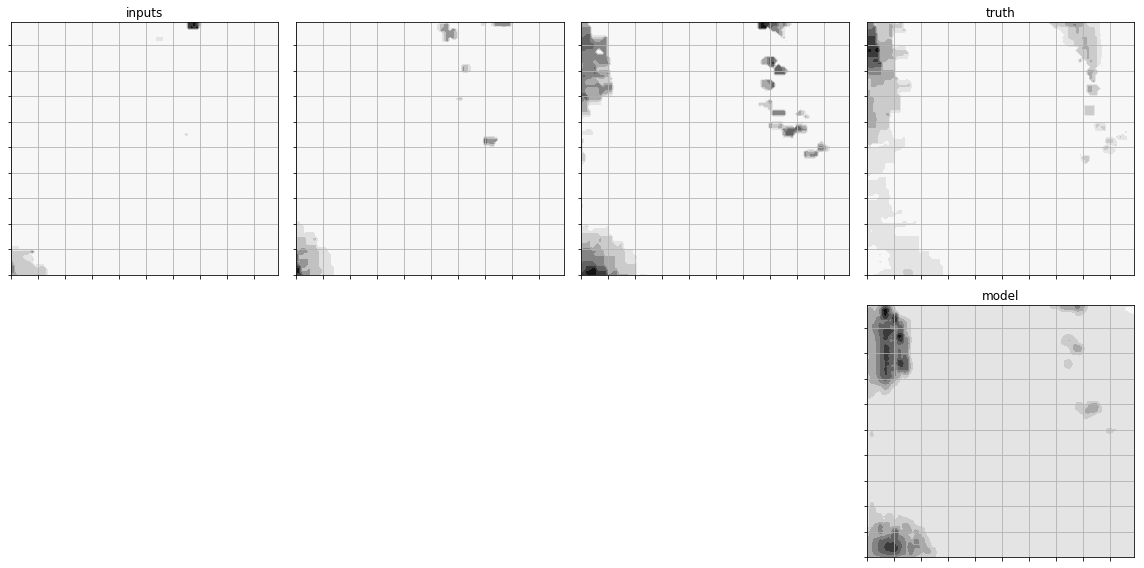

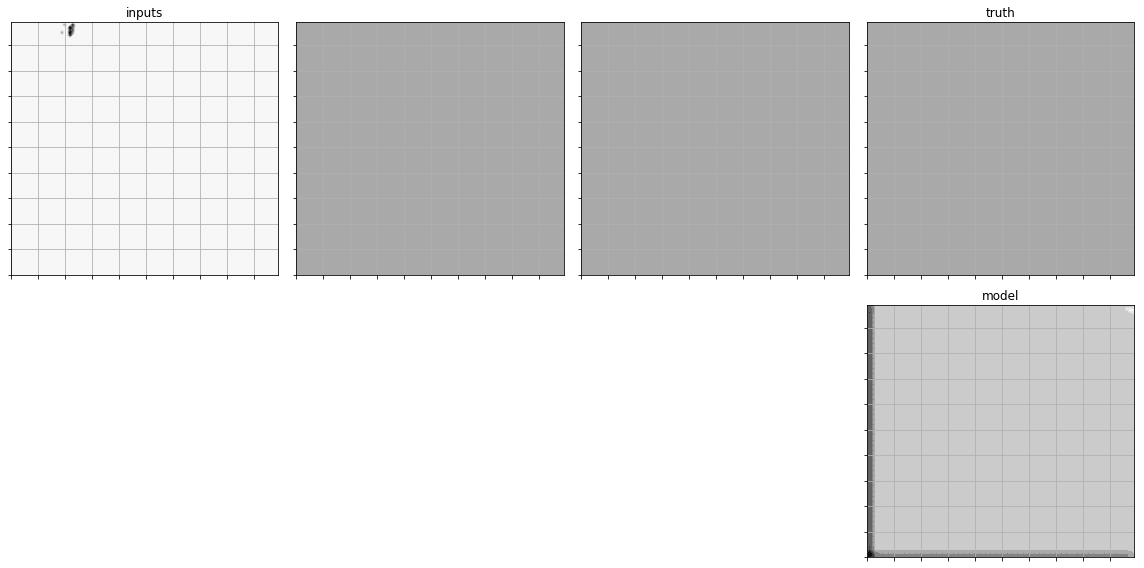

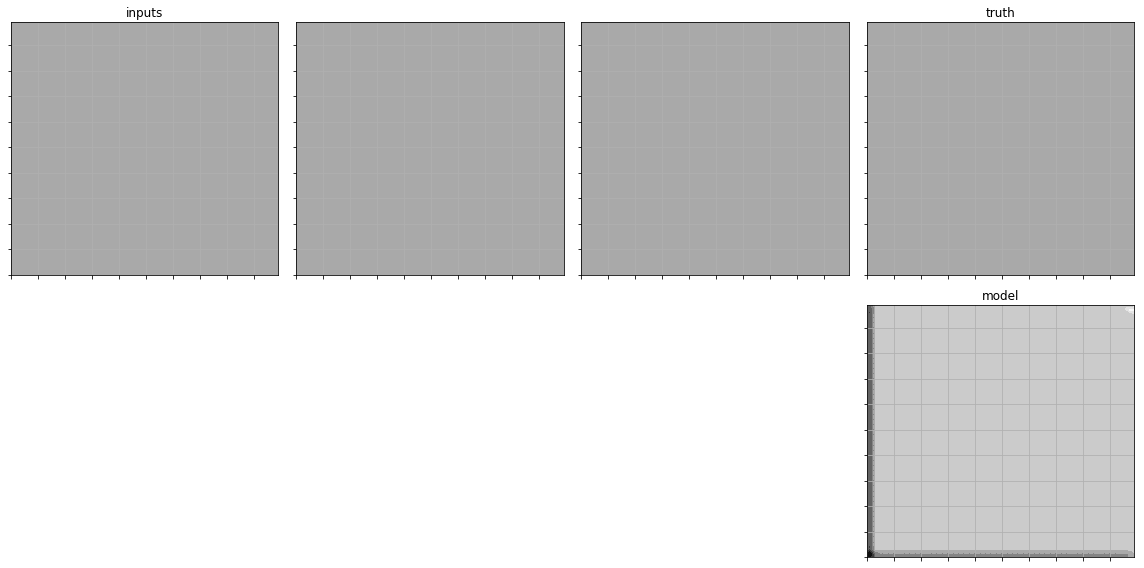

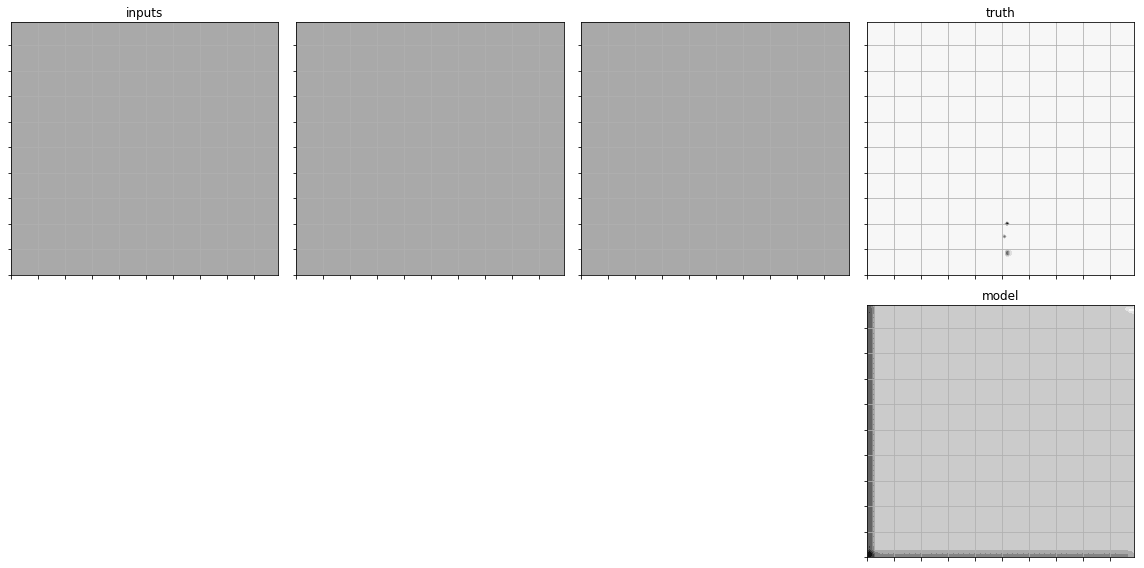

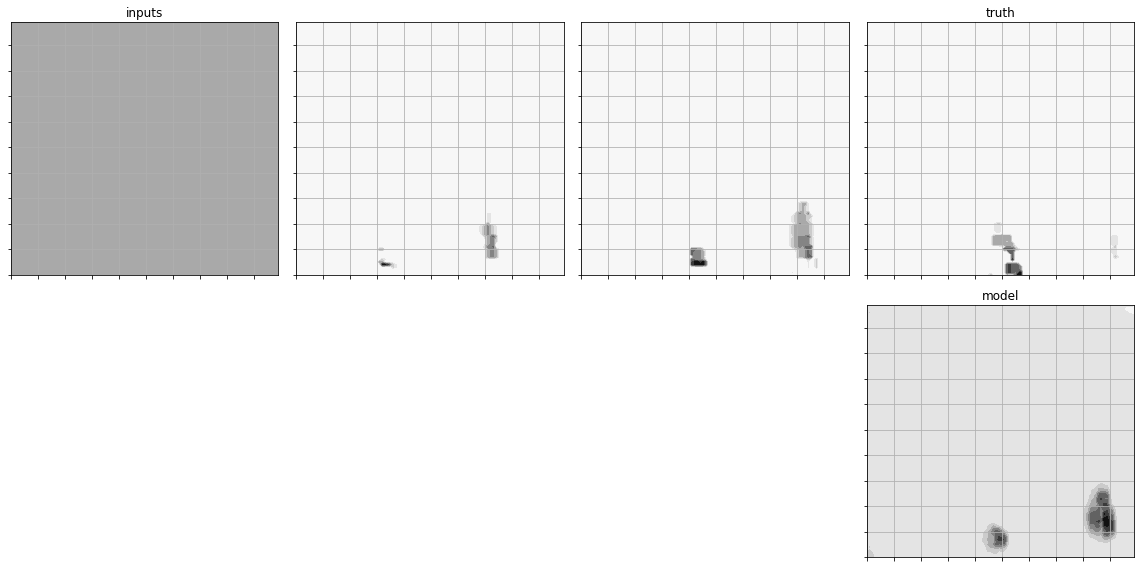

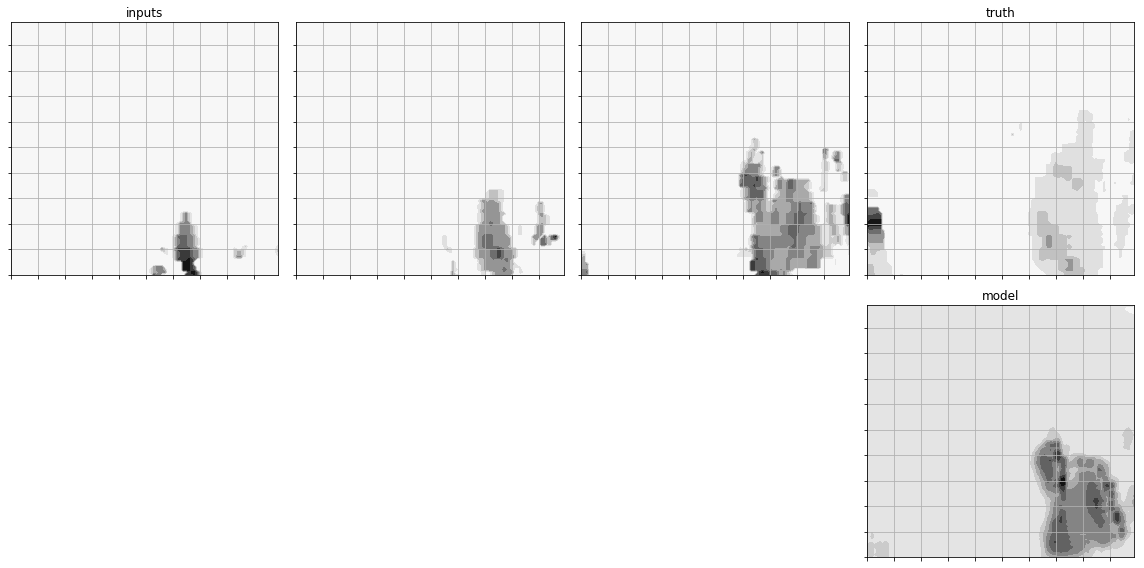

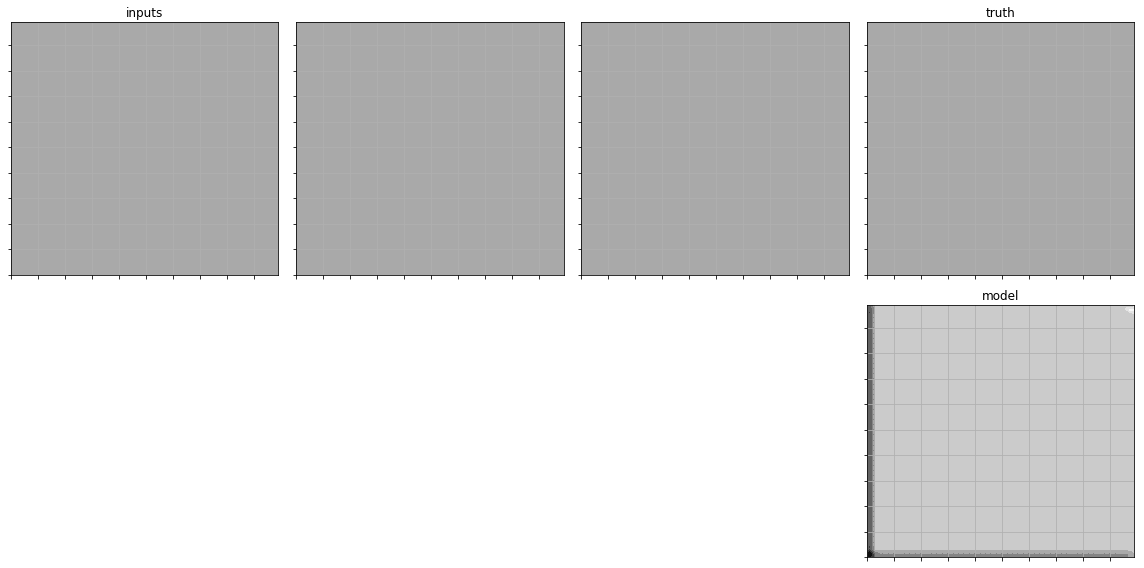

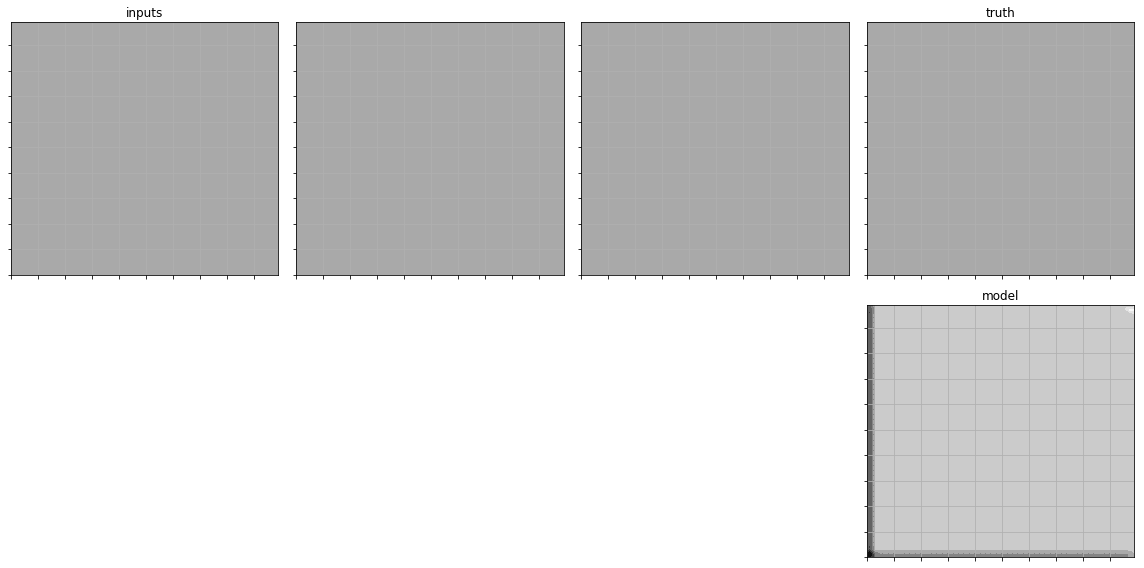

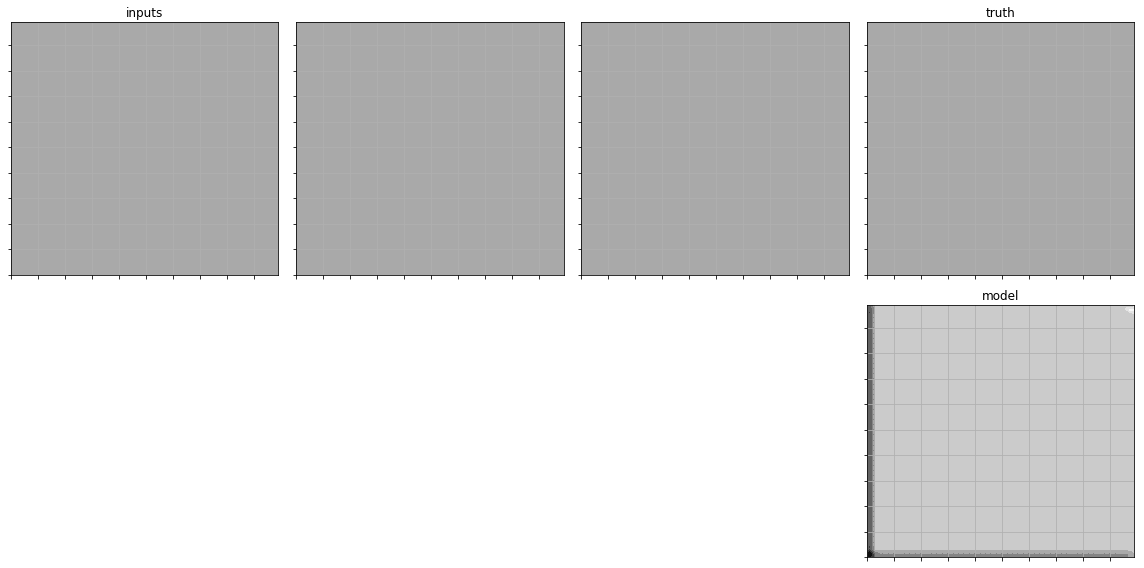

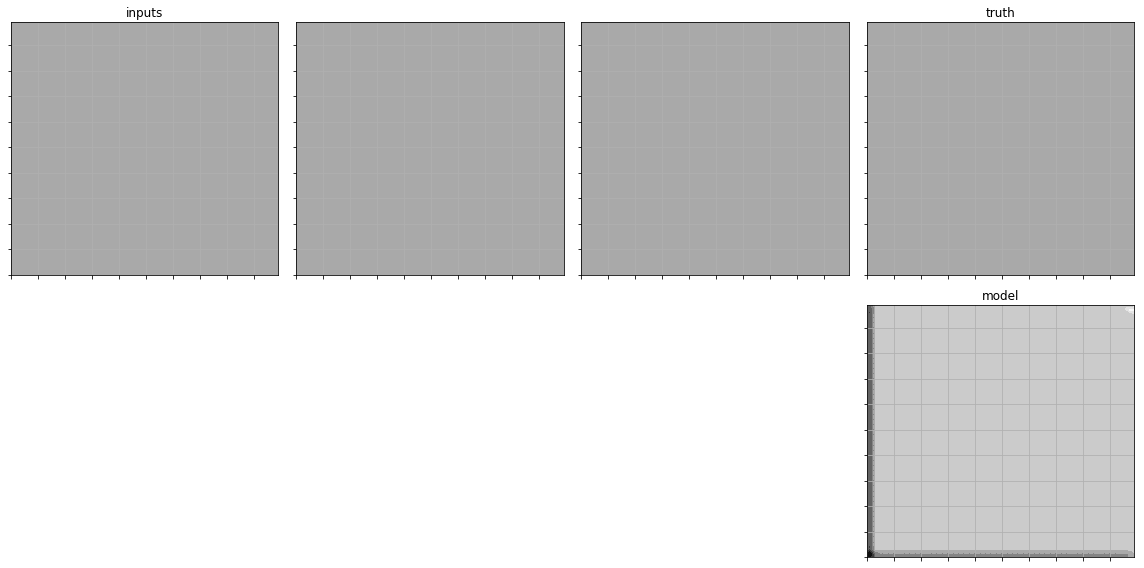

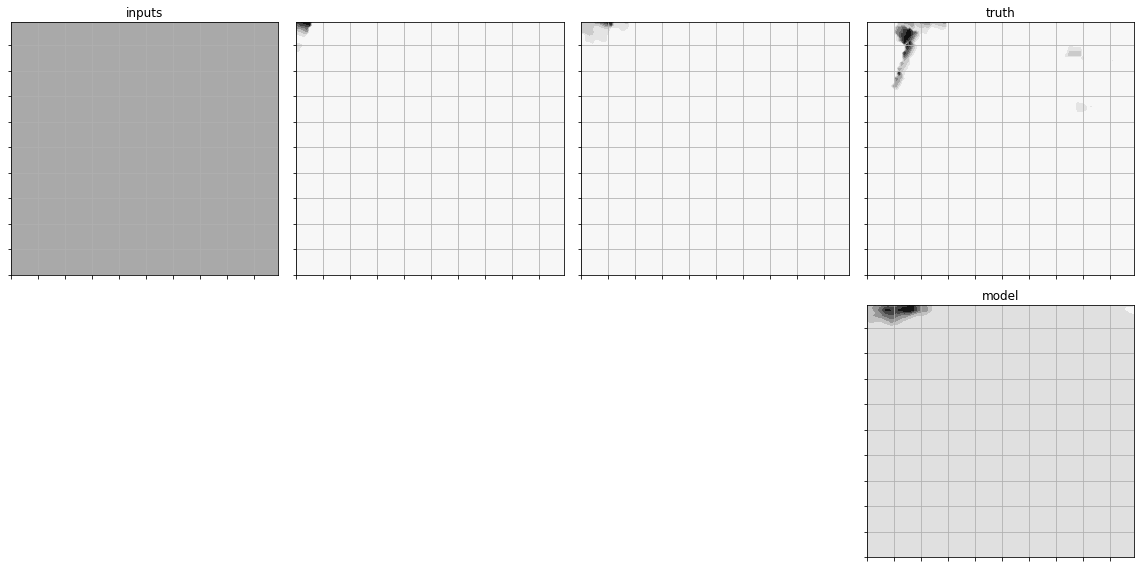

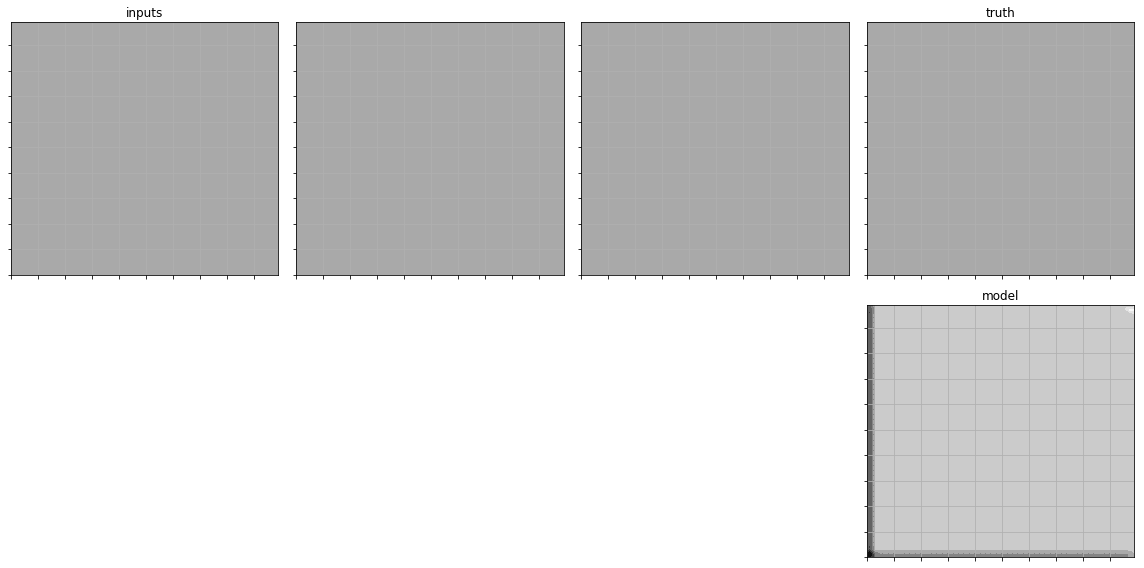

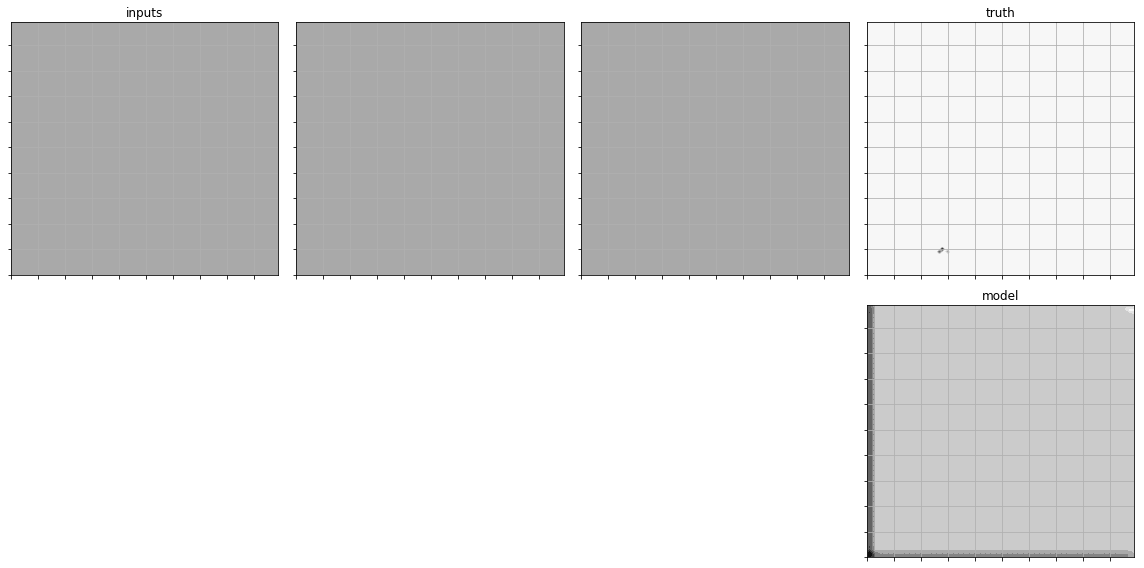

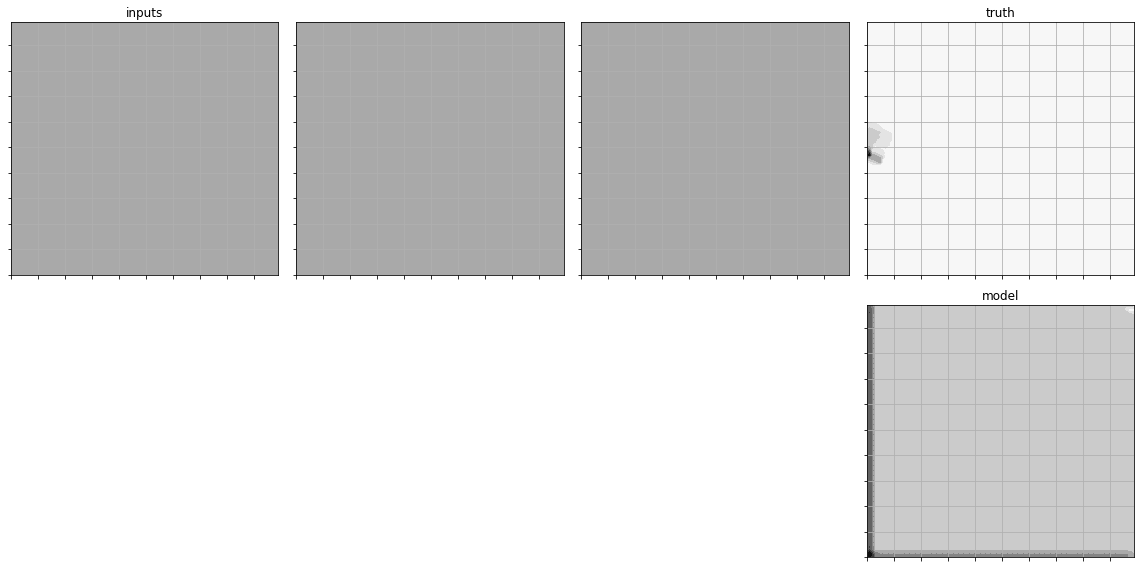

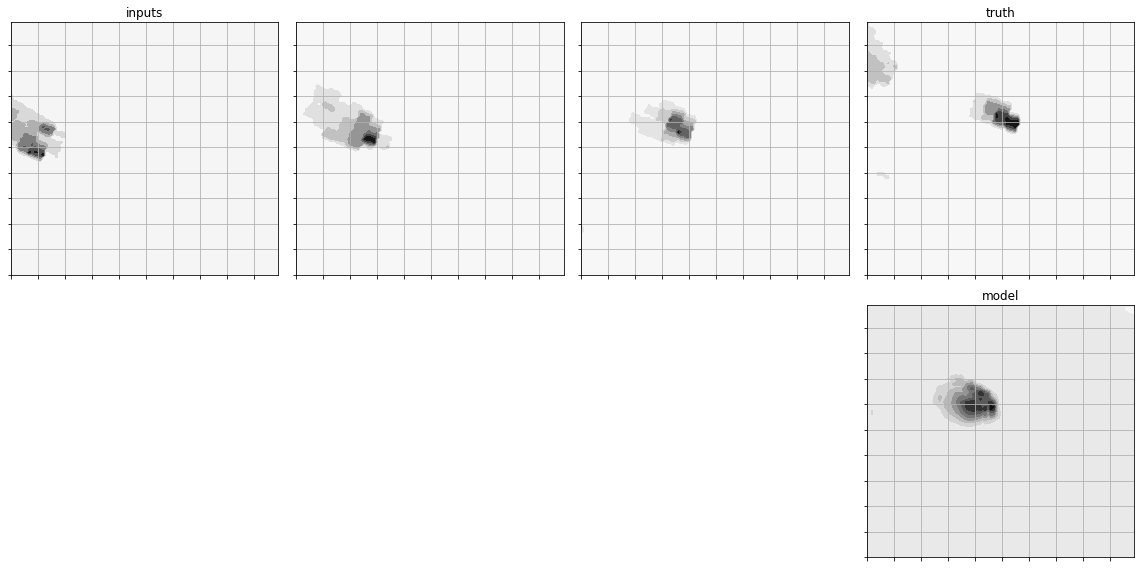

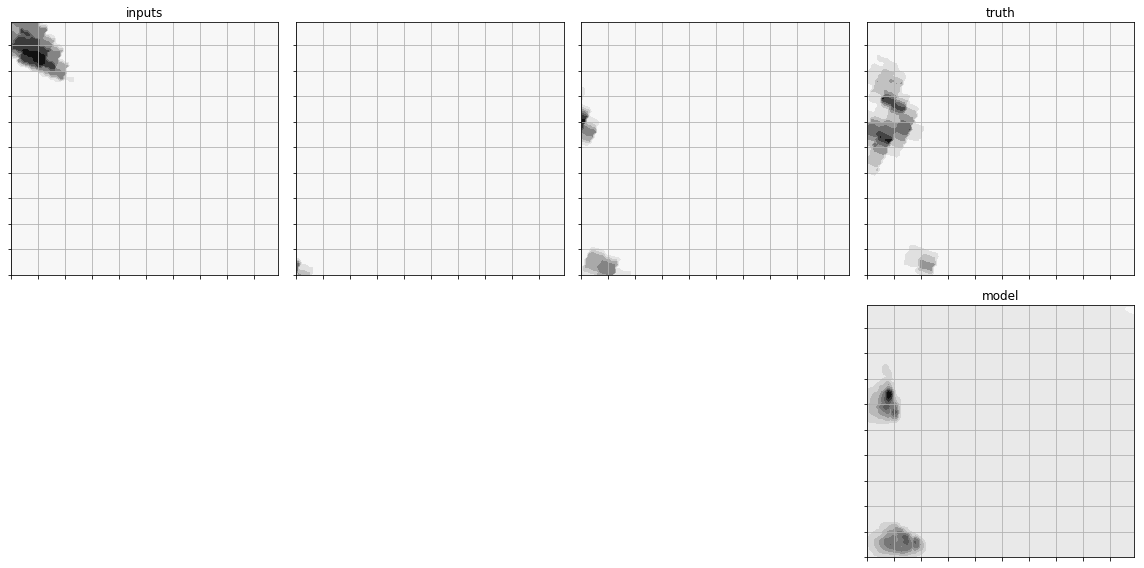

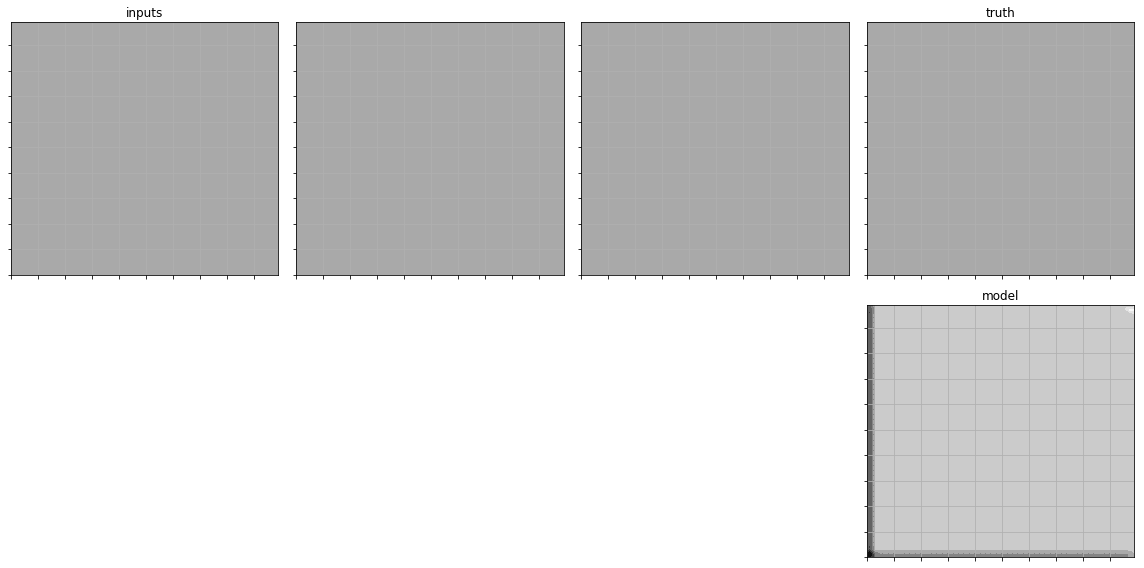

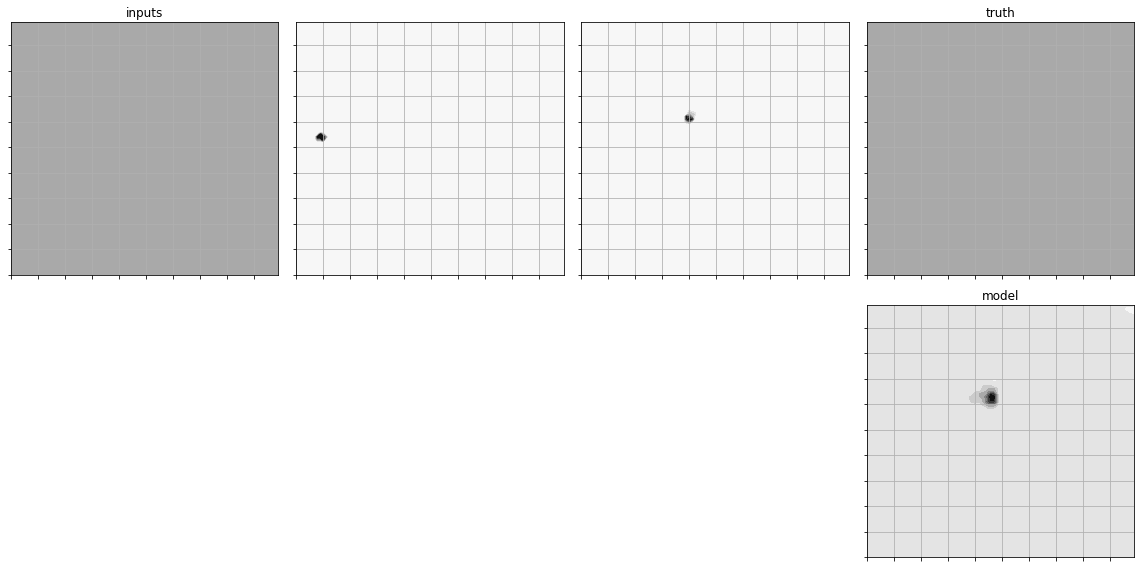

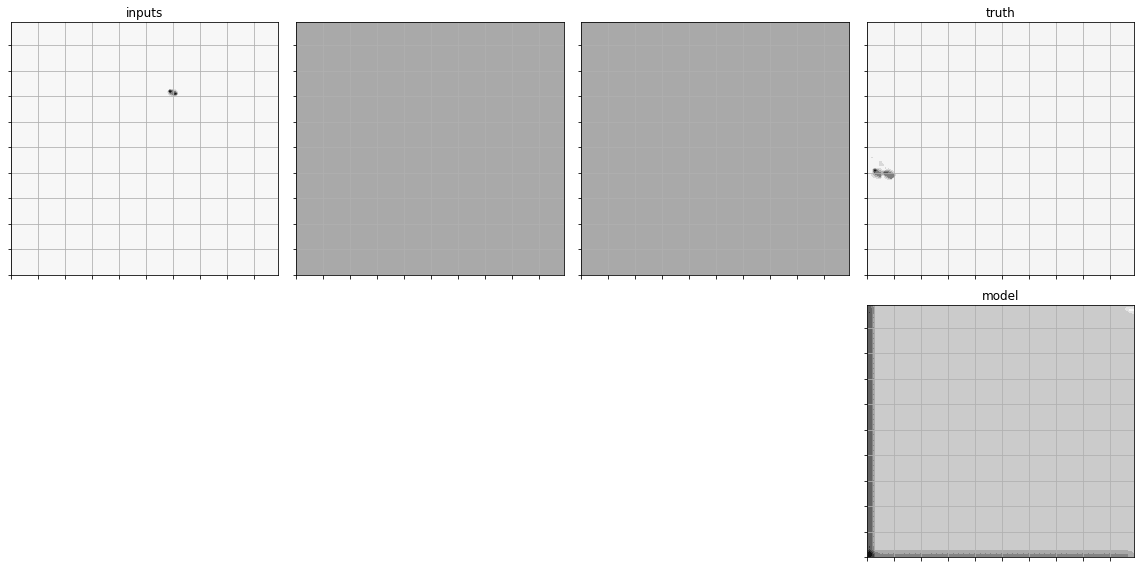

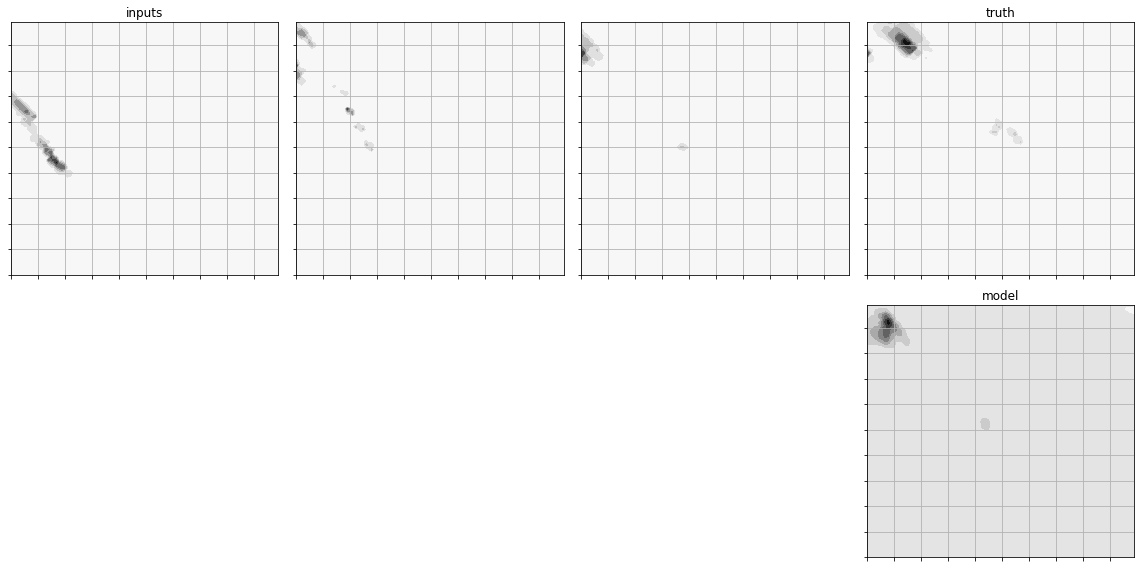

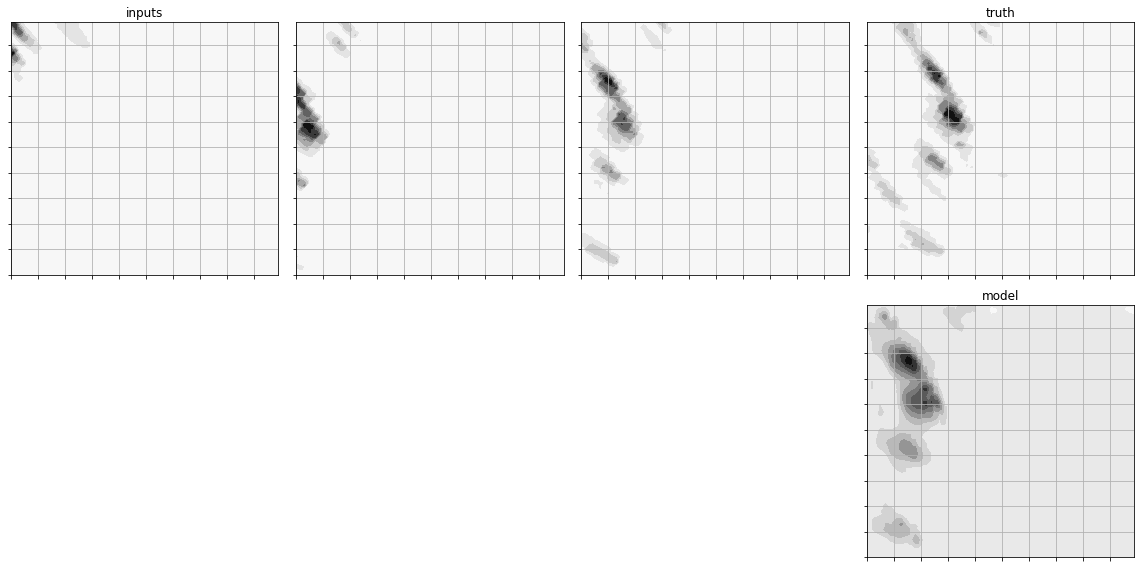

In [49]:
show_outputs(cnn, val_loader)